<a href="https://colab.research.google.com/github/Adarsh-Vemali/Numerical_linear_algebra/blob/main/Cora_Eigenmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Node Representation Learning using Laplacian Eigenmaps



### Install necessary modules and dependencies

In [1]:
! pip install torch_geometric

In [2]:
import os
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import torch
from torch import Tensor
import torch_geometric
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid
import networkx as nx
from networkx.algorithms import community
import time

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
%matplotlib inline

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)

In [4]:
dataset = Planetoid(root=data_dir, name='Cora')
data = dataset[0]

### Exploratory Data Analysis of the CORA dataset

In [5]:
print(data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [6]:
print(f'Number of nodes: {data.num_nodes}')

Number of nodes: 2708


In [7]:
print(f'Number of edges: {data.num_edges}')

Number of edges: 10556


In [8]:
print(f'Has isolated nodes: {data.has_isolated_nodes()}')  # False
print(f'Has self-loops: {data.has_self_loops()}')  # False
print(f'Is undirected: {data.is_undirected()}')  # True

Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [9]:
edge_index = data.edge_index.numpy()
print(edge_index.shape)

(2, 10556)


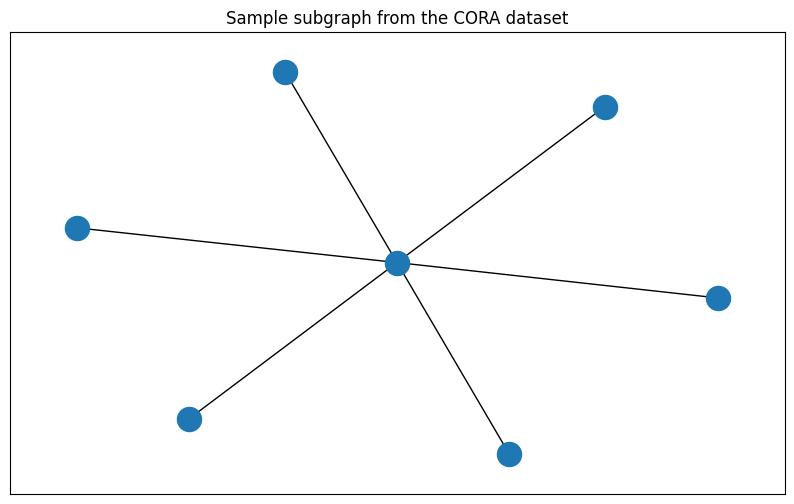

In [10]:
# Plot a sample sub-graph
edge_example = edge_index[:, np.where(edge_index[0]==30)[0]]
node_example = np.unique(edge_example.flatten())

plt.figure(figsize=(10, 6))
G = nx.Graph()
G.add_nodes_from(node_example)
G.add_edges_from(list(zip(edge_example[0], edge_example[1])))
nx.draw_networkx(G, with_labels=False)
plt.title('Sample subgraph from the CORA dataset')
plt.show()

,count,mean,std,min,25%,50%,75%,max
0,2708.0,3.9,5.23,1.0,2.0,3.0,5.0,168.0


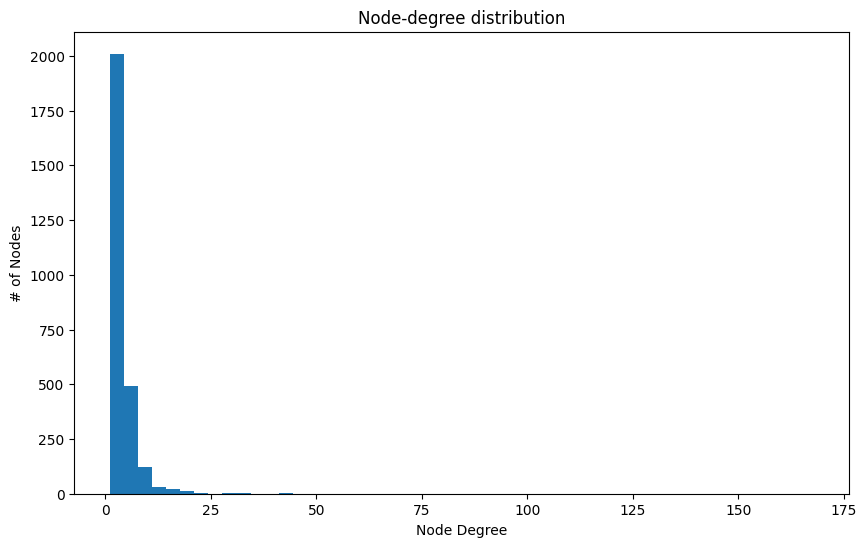

In [11]:
G = to_networkx(data, to_undirected=True)
degrees = [val for (node, val) in G.degree()]
display(pd.DataFrame(pd.Series(degrees).describe()).transpose().round(2))

plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=50)
plt.xlabel("Node Degree")
plt.ylabel('# of Nodes')
plt.title('Node-degree distribution')
plt.show()


In [12]:
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of features: {data.num_node_features}')
print(f'Number of edge features: {data.num_edge_features}')
print(f'Number of classes: {dataset.num_classes}')

Average node degree: 3.90
Number of features: 1433
Number of edge features: 0
Number of classes: 7


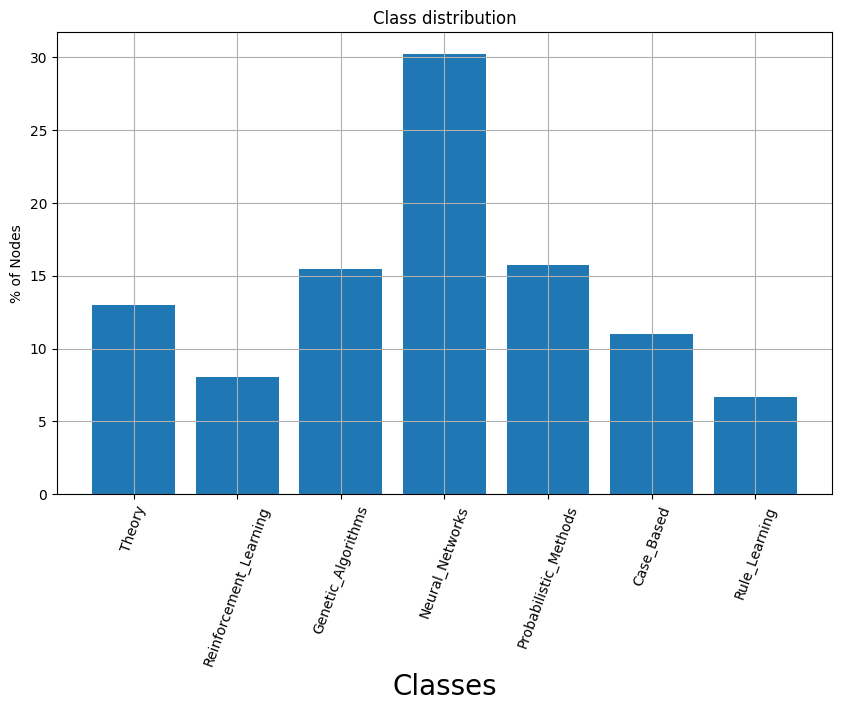

In [13]:
label_dict = {
    0: "Theory",
    1: "Reinforcement_Learning",
    2: "Genetic_Algorithms",
    3: "Neural_Networks",
    4: "Probabilistic_Methods",
    5: "Case_Based",
    6: "Rule_Learning"}

counter = collections.Counter(data.y.numpy())
counter = dict(counter)
count = [x[1] for x in sorted(counter.items())]
total = sum(count)

# Plot the distribution of nodes among classes
plt.figure(figsize=(10, 6))
plt.bar([label_dict[i] for i in range(7)], [i/total*100.0 for i in count])
plt.xlabel("class", size=20)
plt.title('Class distribution')
plt.grid()
plt.xlabel('Classes')
plt.xticks(rotation=70)
plt.ylabel('% of Nodes')
plt.show()


### Eigenmap embeddings of the graph

#### Obtain the Adjacency matrix (A) , Degree matrix (D) and Laplacian matrix (L)

In [14]:
start=time.time()
# Make Adjacency matrix of the graph

num_nodes = np.max(edge_index) +1
A = np.zeros((num_nodes,num_nodes), dtype=int)
edges=list(zip(edge_index[0], edge_index[1]))

# print("Edge Index", '\n', edge_index)
# print("Edges", '\n', edges)

for i in edges:
  A[i[0],i[1]]=1
  A[i[1],i[0]]=1

print('Adjacency Matrix (A)','\n',A)

Adjacency Matrix (A) 
 [[0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 1 0]]


In [15]:
D = np.diag(A.sum(axis=1))
print('Degree Matrix','\n', D , '\n')
print("Degree matrix's shape", '\n', D.shape , '\n')
print("Adjacency matrix's shape", '\n',A.shape , '\n')

Degree Matrix 
 [[3 0 0 ... 0 0 0]
 [0 3 0 ... 0 0 0]
 [0 0 5 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 4 0]
 [0 0 0 ... 0 0 4]] 

Degree matrix's shape 
 (2708, 2708) 

Adjacency matrix's shape 
 (2708, 2708) 



In [16]:
# Unnormalized Laplacian
L = D - A
print('Unnormalized Laplacian matrix', '\n', L,'\n')

Unnormalized Laplacian matrix 
 [[ 3  0  0 ...  0  0  0]
 [ 0  3 -1 ...  0  0  0]
 [ 0 -1  5 ...  0  0  0]
 ...
 [ 0  0  0 ...  1  0  0]
 [ 0  0  0 ...  0  4 -1]
 [ 0  0  0 ...  0 -1  4]] 



#### Perform Eigen-decomposition of Laplacian matrix L

In [17]:
eigenvalues, eigenvectors = np.linalg.eig(L)

eigenvalues = np.real(eigenvalues)
eigenvectors = np.real(eigenvectors)

In [18]:
order = np.argsort(eigenvalues)
eigenvalues = eigenvalues[order]

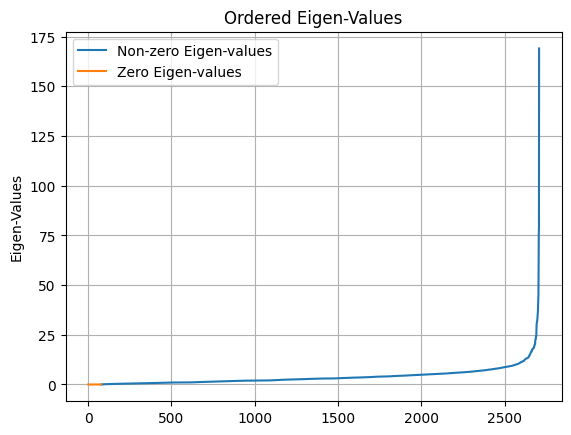

In [19]:
# Plot the Eigen-values from the Eigen-decomposition
point = 0.001

supper = np.ma.masked_where(eigenvalues >= point, eigenvalues)
slower = np.ma.masked_where(eigenvalues < point, eigenvalues)

fig, ax = plt.subplots()
ax.plot(range(len(eigenvalues)), slower , label = 'Non-zero Eigen-values')
ax.plot( range(len(eigenvalues)), supper , label = 'Zero Eigen-values')
ax.legend()
plt.ylabel('Eigen-Values')
plt.title('Ordered Eigen-Values')
ax.grid()
plt.show()

#### Hyperparameter tuning

In [20]:
y=data.y.numpy()
res=[]

# For different values of the embedding_size (d) , we will train an ML classifier and store the performance
for embedding_size in range(8,256):

  # Start index is the first non-zero Eigen-value
  start_index= np.where(eigenvalues>=0.001)[0][0]
  # Eigen-vectors are the next 'd' vectors
  v = eigenvectors[:, order[start_index:(embedding_size+ start_index)]]

  # We will then train an ML model using the Eigen-vectors as the input features, and the node categories as target variable
  X = v
  Y = y

  num_nodes = data.num_nodes
  indices = np.arange(num_nodes)
  random_state = 42
  np.random.seed(random_state)
  np.random.shuffle(indices)

  # Split the data into a 80:20 split. 80% for training and 20% for testing
  split_idx = int(0.8 * num_nodes)  # 80-20 split
  train_idx, test_idx = indices[:split_idx], indices[split_idx:]

  X_train, X_test  = X[train_idx] , X[test_idx]
  y_train, y_test  = y[train_idx] , y[test_idx]

  # Initialize and train the Classifier
  clf = LogisticRegression(random_state=0,max_iter=1000,class_weight='balanced')
  clf.fit(X_train, y_train)

  # Obtain predictions using the classifier and store the performance of the Classifier
  y_pred = clf.predict(X_test)
  res.append([embedding_size, clf.score(X_test, y_test) , f1_score(y_test, y_pred, average='weighted')])


In [21]:
results=pd.DataFrame(res,columns=['d','Accuracy','F1_score'])
results

,d,Accuracy,F1_score
0,8,0.481550,0.455376
1,9,0.509225,0.461734
2,10,0.636531,0.598569
3,11,0.623616,0.573763
4,12,0.619926,0.570103
...,...,...,...
243,251,0.822878,0.822400
244,252,0.821033,0.820767
245,253,0.819188,0.819098
246,254,0.819188,0.819098


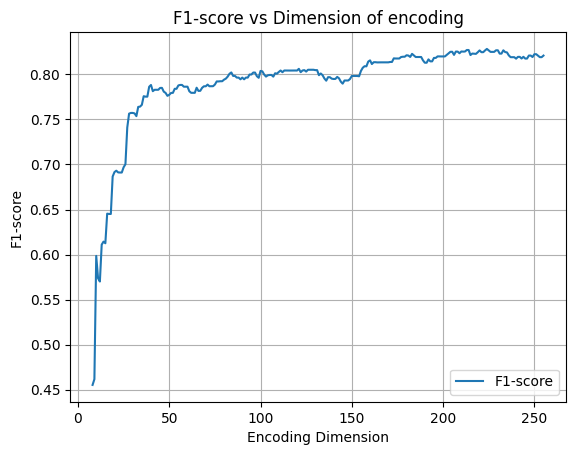

In [22]:
# Plot the F1-score against dimensions
fig=plt.figure()

plt.plot(results['d'],results['F1_score'],label='F1-score')
plt.grid()
plt.title('F1-score vs Dimension of encoding')
plt.legend(loc='lower right')
plt.ylabel('F1-score')
plt.xlabel('Encoding Dimension')
plt.show()


In [23]:
results[results['d']==64]

,d,Accuracy,F1_score
56,64,0.773063,0.779511


#### Node Encoding based on optimized hyperparameters

In [24]:
embedding_size = 64
# v_0 = eigenvectors[:, order[0]]
start_index= np.where(eigenvalues>=0.001)[0][0]
v = eigenvectors[:, order[start_index:(embedding_size+ start_index)]]
# print(v.shape)
mid=time.time()

### Train ML classifier on the data

In [25]:
X = v
Y = y

num_nodes = data.num_nodes
indices = np.arange(num_nodes)
random_state = 42  # Set your desired random state value
np.random.seed(random_state)
np.random.shuffle(indices)
# print(indices)

# Split the dataset in 80:20
split_idx = int(0.8 * num_nodes)  # 80-20 split
train_idx, test_idx = indices[:split_idx], indices[split_idx:]

X_train, X_test  = X[train_idx] , X[test_idx]
y_train, y_test  = y[train_idx] , y[test_idx]


In [26]:
print(X_train.shape)
# print(X_val.shape)
print(X_test.shape)
print()
print(y_train.shape)
# print(y_val.shape)
print(y_test.shape)

(2166, 64)
(542, 64)

(2166,)
(542,)


In [27]:
clf = LogisticRegression(random_state=0,max_iter=1000,class_weight='balanced')

clf.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=0)

In [28]:
inf_st=time.time()
y_pred = clf.predict(X_test)
inf_end=time.time()
print('Inference time', inf_end-inf_st)

Inference time 0.0009405612945556641


In [29]:
print("score on X_train {}".format(clf.score(X_train, y_train)))
# print("score on X_val {}".format(clf.score(X_val, y_val)))
print("score on X_test {}".format(clf.score(X_test, y_test)))

print("F1-Score", f1_score(y_test, y_pred, average='weighted'))
end=time.time()

score on X_train 0.7456140350877193
score on X_test 0.7730627306273062
F1-Score 0.7795114097944404


In [30]:
print('Total time', end-start)
print('NLA time', mid-start)
print('ML time', end-mid)

Total time 87.5333354473114
NLA time 87.32381463050842
ML time 0.20952081680297852
